In [16]:
# Standard Imports
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import chart_studio.plotly as py
#Import plotly.express, naming convention as px
import plotly.express as px
import plotly.graph_objs as go #importing graphical objects
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
# Plot Settings
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.rcParams['agg.path.chunksize'] = 10000
import sys
HELPERS_PATH = os.path.join("..", "Functions and Packages")
sys.path.append(HELPERS_PATH)
from helpers import visualization, preprocessing
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Types and Estimators

Let's work with our happiness dataset again. 

In [17]:
happiness_data = pd.read_csv("../data/happiness.csv")
happiness_data.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298


### OLS

**OLS** stands for Ordinary Least Squares.  This is the most common method, and follows the standard Sklearn API for construction.  Use `LinearRegression` as the estimator.

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = happiness_data[['GDP per capita', 'Generosity']]
y = happiness_data[['Score']]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Construct lin_reg object
lin_reg = LinearRegression()

# Fit to data
lin_reg.fit(X_train, y_train)

# Predict
y_pred = lin_reg.predict(X_test)

#### Visualizing

In [19]:
def plot_multiple_happiness_regression():
    fig = px.scatter_3d(data_frame = happiness_data, x = 'Generosity', y = 'GDP per capita', z = 'Score')
    #I like smaller markers
    fig.update_traces(marker = dict(size = 5))
    # Get the min and max of our x and y axes
    x_min, x_max = X_test['Generosity'].min(), X_test['Generosity'].max()
    y_min, y_max = X_test['GDP per capita'].min(), X_test['GDP per capita'].max()

    # Create the mesh (interval) size
    mesh_size = 0.03

    # Create the ranges of the axes
    xrange = np.arange(x_min, x_max, mesh_size)
    yrange = np.arange(y_min, y_max, mesh_size)

    # Create MeshGrid
    xx, yy = np.meshgrid(xrange, yrange)

    # Predict the model on the raveled (flattened) versions of the xx and yy gen'd by MeshGrid function
    y_pred = lin_reg.predict(np.c_[xx.ravel(), yy.ravel()])

    #Reshape to the xx so all our dimensions are the same for our goSurface
    y_pred = y_pred.reshape(xx.shape)

    # Add traces, with our z being the y_preds
    fig.add_traces(go.Surface(x= xrange, y = yrange, z=y_pred, name="predictions"))
    fig.show()

In [20]:
plot_multiple_happiness_regression()

We can look at multiple OLS regressions with seaborn using `sns.pairplot(data, x_vars, y_vars, kind = 'reg'`

In [21]:
happiness_data.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298


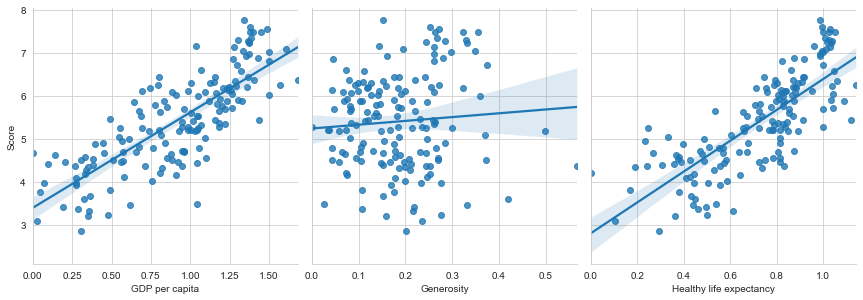

In [27]:
sns.set_style("whitegrid")
sns.pairplot(data = happiness_data, x_vars=['GDP per capita', 'Generosity', 'Healthy life expectancy'], y_vars='Score', height = 4, aspect=1, kind = 'reg')

#### Evaluating

Let's take a look at our intercept and coefficients.

In [9]:
# Check coef
print('Coefficients: ', lin_reg.coef_)

# MSE
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients:  [[2.27861606 2.09810539]]
Mean squared error: 0.61
Coefficient of determination: 0.38


#### Statsmodels

For more advanced techniques and hypothesis testing, see [this](http://localhost:8889/notebooks/MLProjects/Notes/Statsmodels.ipynb) notebook.

### Ridge Regression

Plots the sum of the squared residuals vs slope values, constantly changing the line through the data value. 

Imposes a penalty, which is added to the sum of the squared residuals.  This **prevents overfitting**: 
    \begin{equation}
  \lambda * \mbox{Slope}^2
\end{equation}

The whole model: 

<img src="https://miro.medium.com/max/700/1*CoFy4DZw6arLiurhl-Nhig.png" />

In this case, alpha is lambda, and w is slope.

In [86]:
# Import Ridge
from sklearn.linear_model import Ridge

# Construct Estimator - alpha = 1, meaning linear, nothing is changing, same effect as LinearRegression
ridge = Ridge(alpha = 1)

#Let's make this one feature and one y value
X = happiness_data[['GDP per capita']]
y = happiness_data[['Score']]

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y)

#Fit model
ridge.fit(X_train, y_train)

#Predict
y_pred = ridge.predict(X_test)

Let's view the coefficient, w, which represents the slope

In [87]:
w = ridge.coef_
w 

array([[2.08713558]])

In [ ]:
from visualization import plot_lin_reg

In [97]:
plot_lin_reg(ridge, X, y)

Finally, exporting this to chart-studio, and adding a little formatting . . . 

In [65]:
from IPython.display import HTML
HTML('<iframe width="900" height="800" frameborder="0" scrolling="no" src="//plotly.com/~lukeanglin/6.embed"></iframe>')

/Users/lukeanglin/opt/anaconda3/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning:

Consider using IPython.display.IFrame instead



Let's see what happens if we increase $\alpha$ (also known as $\lambda$) to 1000.

In [66]:
y_range.shape

(100, 1)

In [67]:
# Construct Estimator - alpha = 1000, higher penalty, lower bias.
ridge = Ridge(alpha = 1000)

#Fit and predict
ridge.fit(X_train, y_train)
y_range = ridge.predict(X_range.reshape(-1, 1))

#Save to CSV for Chart-Studio Formatting
np.savetxt('../data/ridge_predictions_for_plotly.csv', y_range, delimiter = ',')

#Show new chart
HTML('<iframe width="900" height="800" frameborder="0" scrolling="no" src="//plotly.com/~lukeanglin/8.embed"></iframe>')

/Users/lukeanglin/opt/anaconda3/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning:

Consider using IPython.display.IFrame instead



### Lasso Regression

Similar to ridge regression, imposes a penalty to **prevent overfitting**

$$\lvert \lambda * \mbox{Slope} \rvert$$

The whole model: 

<img src="https://www.analyticsvidhya.com/wp-content/uploads/2015/08/Ridge2.png" />

In [68]:
# Import Lasso
from sklearn.linear_model import Lasso

# Construct Estimator - alpha = 1, meaning linear, nothing is changing, same effect as LinearRegression
lasso = Lasso(alpha = 1)

#Let's make this one feature and one y value
X = happiness_data[['GDP per capita']]
y = happiness_data[['Score']]

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y)

#Fit model
lasso.fit(X_train, y_train)

#Predict
y_pred = lasso.predict(X_test)

#Show coef
l

array([0.])

### Ridge vs. Lasso

Both are considered **regularizing** estimators.  This means that they introduce some bias for a significant drop in variance.

Differences
* Ridge can only shrink features asymptotically close to zero
* Lasso can shrink features all the way to zero
* Lasso will therefore **completely exclude** useless variables, while ridge will make them **less effective**

Summary:  If you have mostly **useful variables**, use ridge, otherwise, use lasso.

### Elastic Net

What if we have a model with **tons of variables** and we don't know whether or not most of them are useful?  We use elastic net in this scenario, another regularization method.

Combines the elastic penalty and the ridge penalty:

$$\lvert \lambda_{1} * \mbox{Slope} \rvert + \lambda_{2} * \mbox{Slope}^2$$

Notice the subscripts on the $\lambda\mbox{'s}$.  

Elastic Net is best at dealing with **multiple, correlated parameters.**

## Choosing

For a [table format](https://airtable.com/shrQ5rfksG64QobIy/tblkAQbukd3Al0OT6)

<img src="https://miro.medium.com/max/700/1*_Wx0vKokbXd20HlbLKpj2A.jpeg" />